**Project Descriptioin:**
Cybersecurity scanning and detection often involves capturing network packets using industry standard sniffers and analyzing headers to monitor and detect threats. This project scenario involves gathering network traffic information and analyzing it to Identify threat or normal traffic. Once Identified we will then classify it into various bins to identify the type of threats.
This project has two parts ( Part I & II), in total 4 files.

**Part I**  EDA ( Exploratory Data Analysis), model experimentation, choosing the right model, tuning and then perform binary classification.


*   File 1: cyber_ml_capstone.ipynb
*   File 2: optimized_model.ipynb
*   File 2: optimized_model.ipynb

**Part II**  Leverage Neural Networks, evaluate various models, choose the right model, fine tune it and perform multiclass classification.


*   File 4: neural_net_multi_class_classification.ipynb


** This is File 2 of 4: optimized_model.ipynb **

In [1]:
from google.colab import drive
from sklearn.model_selection import train_test_split
drive.mount('/content/drive', force_remount=True)
import pandas as pd
network = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AIML/capstone/capstone-dataset/Train_Test_Network.csv')
#70% split up for train test and 30% is being saved for final testing of the model.
net_df = network.drop(['service','src_ip', 'dst_ip', 'weird_notice', 'weird_addl', 'weird_name', 'http_trans_depth',
       'http_method', 'http_uri', 'http_version', 'http_request_body_len',
       'http_response_body_len', 'http_status_code', 'http_user_agent',
       'http_orig_mime_types', 'http_resp_mime_types', 'ssl_cipher',
       'ssl_subject', 'dns_query', 'ssl_issuer', 'src_port', 'dst_port', 'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected', 'ssl_version', 'ssl_established', 'ssl_resumed', 'ts'], axis=1)
#net_df['service'] = net_df['service'].replace('-', 'Unknown')
netsc_df = net_df.drop(['type'], axis=1)
#print(netsc_df.shape)
#print(netsc_df.columns)
X_trntst, X_co, y_trntst, y_co = train_test_split(netsc_df.drop(['label'], axis = 1), netsc_df['label'], test_size=0.3, random_state = 442, stratify = netsc_df['label'])
X_train, X_test, y_train, y_test = train_test_split(X_trntst, y_trntst, test_size=0.3, random_state = 442, stratify = y_trntst)
netsc_df.head()
#print(netsc_df.isnull().sum())
#print(netsc_df['service'].value_counts())


Mounted at /content/drive


,proto,duration,src_bytes,dst_bytes,conn_state,missed_bytes,src_pkts,src_ip_bytes,dst_pkts,dst_ip_bytes,dns_qclass,dns_qtype,dns_rcode,label
0,tcp,80549.530260,1762852,41933215,OTH,0,252181,14911156,2,236,0,0,0,0
1,udp,0.000000,0,0,S0,0,1,63,0,0,0,0,0,0
2,tcp,0.000000,0,0,OTH,0,0,0,0,0,0,0,0,0
3,tcp,0.000000,0,0,OTH,0,0,0,0,0,0,0,0,0
4,udp,0.000549,0,298,SHR,0,0,0,2,354,0,0,0,0


In [2]:
##
#establishing Baseline accuracy
##
from sklearn.metrics import accuracy_score
Baccuracy = 0.0
print('Majority of network traffic is normal indicated by label 0, attach traffic is indicated by label 1')
print(netsc_df['label'].value_counts(normalize=True))
majority_class = netsc_df['label'].value_counts().idxmax()
baseline_predictions = [majority_class] * len(netsc_df['label'])
#Calculate the accuracy of the baseline model:
Baccuracy = accuracy_score(netsc_df['label'], baseline_predictions)
print("Baseline Accuracy:", Baccuracy)

Majority of network traffic is normal indicated by label 0, attach traffic is indicated by label 1
0    0.650699
1    0.349301
Name: label, dtype: float64
Baseline Accuracy: 0.6506985248664441


In [3]:
print('carved out final test size X', X_co.shape, 'carved out final test size y', y_co.shape)
print('train size X', X_train.shape, 'train size y', y_train.shape, 'test size y', 'test size X', X_test.shape, 'test size y', y_test.shape)

carved out final test size X (138313, 13) carved out final test size y (138313,)
train size X (225911, 13) train size y (225911,) test size y test size X (96819, 13) test size y (96819,)


In [4]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Assuming X_trntst, y_trntst are defined or loaded earlier in the code
# Splitting the data into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(X_trntst, y_trntst, test_size=0.3, random_state=442) # Its assigned in the above block of code

# Define numeric and categorical features
numeric_features = ['duration', 'src_bytes', 'dst_bytes', 'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes']
categorical_features = ['dns_rcode', 'dns_qtype', 'dns_qclass', 'conn_state', 'proto']

# Preprocessing pipelines for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Random Forest pipeline to select top 15 features
rf_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(RandomForestClassifier(max_depth=15, min_samples_split=2, n_estimators=300))),
    ('classifier', RandomForestClassifier(max_depth=15, min_samples_split=2, n_estimators=300))
])

# Training the pipeline with Random Forest Classifier to get top 15 features
rf_clf.fit(X_train, y_train)

# Selecting top 15 feature indices
selected_features_indices = rf_clf.named_steps['feature_selection'].get_support(indices=True)

# Creating KNN and RF pipelines using the selected features
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(estimator=rf_clf.named_steps['classifier'], max_features=15)),
    ('classifier', KNeighborsClassifier(n_neighbors=5, p=1, weights='distance'))
])

rf_eval_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(estimator=rf_clf.named_steps['classifier'], max_features=15)),
    ('classifier', rf_clf.named_steps['classifier'])
])

# Assuming X_co, y_co are defined or loaded earlier in the code
# Assuming Baccuracy is defined elsewhere
# Fit pipelines on available data
knn_pipeline.fit(X_train, y_train)
rf_eval_pipeline.fit(X_train, y_train)

# Predict using the fitted pipelines
knn_pred = knn_pipeline.predict(X_test)
knn_pred_co = knn_pipeline.predict(X_co)
rf_pred = rf_eval_pipeline.predict(X_test)
rf_pred_co = rf_eval_pipeline.predict(X_co)

# Calculating accuracy scores
knn_accuracy = accuracy_score(y_test, knn_pred)
knn_bal_acc_test = np.mean(y_test == knn_pred)
knn_bal_acc_co = np.mean(y_co == knn_pred_co)

rf_accuracy = accuracy_score(y_test, rf_pred)
rf_bal_acc_test = np.mean(y_test == rf_pred)
rf_bal_acc_co = np.mean(y_co == rf_pred_co)

# Printing accuracy scores
print("Baseline Accuracy:", Baccuracy)
print(f"KNN Classifier Accuracy score: {knn_accuracy:.4f}")
print(f"KNN Classifier Balanced Accuracy from test set: {knn_bal_acc_test:.4f}")
print(f"KNN Classifier Balanced Accuracy from new data: {knn_bal_acc_co:.4f}")

print(f"Random Forest Classifier Accuracy score: {rf_accuracy:.4f}")
print(f"Random Forest Classifier Balanced Accuracy from test set: {rf_bal_acc_test:.4f}")
print(f"Random Forest Classifier Balanced Accuracy from new data: {rf_bal_acc_co:.4f}")

Baseline Accuracy: 0.6506985248664441
KNN Classifier Accuracy score: 0.9864
KNN Classifier Balanced Accuracy from test set: 0.9864
KNN Classifier Balanced Accuracy from new data: 0.9865
Random Forest Classifier Accuracy score: 0.9899
Random Forest Classifier Balanced Accuracy from test set: 0.9899
Random Forest Classifier Balanced Accuracy from new data: 0.9897


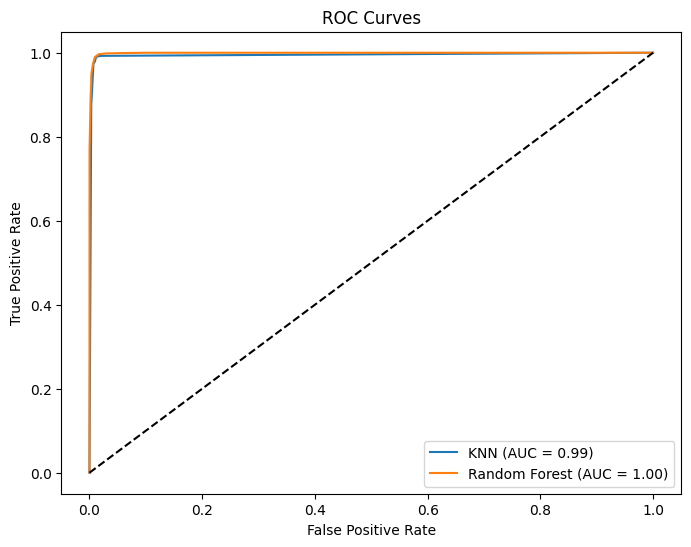

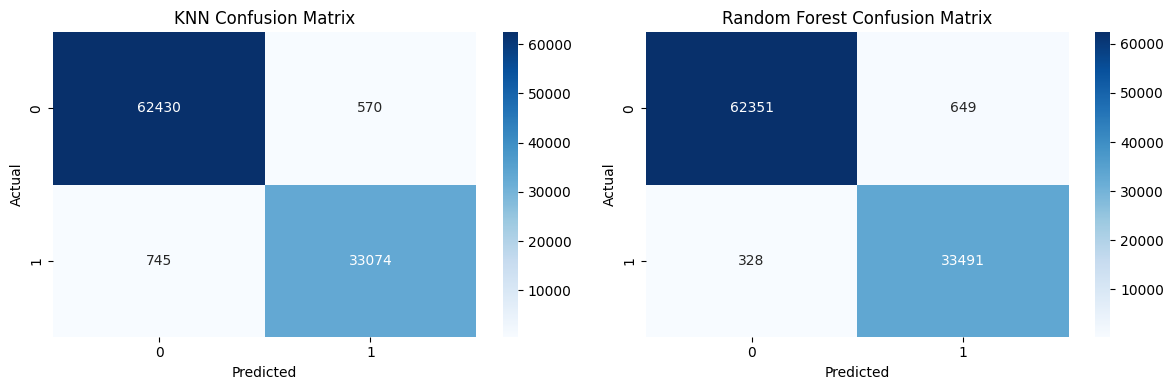

In [5]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate ROC curve for KNN classifier
knn_probs = knn_pipeline.predict_proba(X_test)
knn_probs = knn_probs[:, 1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, knn_probs)
auc_knn = roc_auc_score(y_test, knn_probs)

# Calculate ROC curve for Random Forest classifier
rf_probs = rf_eval_pipeline.predict_proba(X_test)
rf_probs = rf_probs[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf_probs)
auc_rf = roc_auc_score(y_test, rf_probs)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Confusion matrix for KNN classifier
knn_cm = confusion_matrix(y_test, knn_pred)

# Confusion matrix for Random Forest classifier
rf_cm = confusion_matrix(y_test, rf_pred)

# Plot confusion matrices
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Blues')
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()